In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import os

current_dir = os.getcwd()
print("Current working directory:", current_dir)


PATH = "../../"
# Estimate
X_train_estimated_a: pd.DataFrame = pd.read_parquet(
    PATH + 'A/X_train_estimated.parquet')
X_train_estimated_b: pd.DataFrame = pd.read_parquet(
    PATH + "B/X_train_estimated.parquet")
X_train_estimated_c: pd.DataFrame = pd.read_parquet(
    PATH + "C/X_train_estimated.parquet")

# Test estimates
X_test_estimated_a: pd.DataFrame = pd.read_parquet(
    PATH + "A/X_test_estimated.parquet")
X_test_estimated_b: pd.DataFrame = pd.read_parquet(
    PATH + "B/X_test_estimated.parquet")
X_test_estimated_c: pd.DataFrame = pd.read_parquet(
    PATH + "C/X_test_estimated.parquet")

# Observations
X_train_observed_a: pd.DataFrame = pd.read_parquet(
    PATH + "A/X_train_observed.parquet")
X_train_observed_b: pd.DataFrame = pd.read_parquet(
    PATH + "B/X_train_observed.parquet")
X_train_observed_c: pd.DataFrame = pd.read_parquet(
    PATH + "C/X_train_observed.parquet")

# Targets
Y_train_observed_a: pd.DataFrame = pd.read_parquet(
    PATH + "A/train_targets.parquet")
Y_train_observed_b: pd.DataFrame = pd.read_parquet(
    PATH + "B/train_targets.parquet")
Y_train_observed_c: pd.DataFrame = pd.read_parquet(
    PATH + "C/train_targets.parquet")

test_df_example = pd.read_csv(PATH + "test.csv")

best_submission: pd.DataFrame = pd.read_csv(
    PATH + "mikael/submissions/fourth_submission.csv")

optins = {
    "randomize": False,
    "consecutive_threshold": 6,
    "normalize": False,
    "group_by_hour": True,
    "unzip_date_feature": True,
}

# make a options class with the options as attributes


class Options:
    randomize = False
    consecutive_threshold = 6
    normalize = False
    group_by_hour = True
    unzip_date_feature = True

    def __init__(self, randomize=False, consecutive_threshold=6, normalize=False, group_by_hour=True, unzip_date_feature=True) -> None:
        self.randomize = randomize
        self.consecutive_threshold = consecutive_threshold
        self.normalize = normalize
        self.group_by_hour = group_by_hour
        self.unzip_date_feature = unzip_date_feature


class Pipeline:

    def __init__(self):
        pass

    def get_combined_data(self, test_data=False):
        locations = ["A", "B", "C"]
        dfs = []
        for index, location in enumerate(locations):
            if test_data:
                dfs.append(self.get_test_data(location))
            else:
                dfs.append(self.get_data(location))

            dfs[index] = self.onehot_location(dfs[index], location)
        df = pd.concat(dfs).reset_index(drop=True)

        if test_data:
            return df
        return df[[c for c in df if c not in ['pv_measurement']] +  # pv measurement is the target and is at the end columns
                  ['pv_measurement']]

    def get_data(self, location: str, keeptime=False) -> pd.DataFrame:
        train, targets = self.get_training_data_by_location(location)
        return self.handle_data(train, targets, keeptime=keeptime)

    def get_test_data(self, location: str) -> pd.DataFrame:
        test_data = self.get_test_data_by_location(location)
        return self.handle_data(test_data)

    def handle_data(self, df, targets=pd.DataFrame(), keeptime=False):
        df["date_calc"] = pd.to_datetime(df["date_calc"])
        df["date_forecast"] = pd.to_datetime(df["date_forecast"])

        # df = self.add_time_since_calucation(df)
        df = self.onehot_estimated(df)
        df = self.unzip_date_feature(df)
        df = self.grouped_by_hour(df)

        df["time"] = df["date_forecast"]
        df.drop(["date_forecast"], axis=1, inplace=True)

        if not targets.empty:
            df = self.merge_train_target(df, targets)

        df.drop(columns=["time"], axis=1, inplace=True)

        df = self.absolute_values(df)
        return df

    # –––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– helper funciton ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

    def get_training_data_by_location(self, location):
        if location == "A":
            X_train_observed_x = X_train_observed_a
            X_train_estimated_x = X_train_estimated_a
            Y_train_x = Y_train_observed_a
        elif location == "B":
            X_train_observed_x = X_train_observed_b
            X_train_estimated_x = X_train_estimated_b
            Y_train_x = Y_train_observed_b
        elif location == "C":
            X_train_observed_x = X_train_observed_c
            X_train_estimated_x = X_train_estimated_c
            Y_train_x = Y_train_observed_c
        else:
            raise Exception("location must be A, B or C")
        train = pd.concat(
            [X_train_observed_x, X_train_estimated_x]).reset_index(drop=True)
        return train, Y_train_x

    def get_test_data_by_location(self, location: str,  normalize=False) -> pd.DataFrame:
        if location == "A":
            df = X_test_estimated_a
        elif location == "B":
            df = X_test_estimated_b
        elif location == "C":
            df = X_test_estimated_c
        else:
            raise Exception("location must be A, B or C")
        return df.copy()

    def unzip_date_feature(self, df: pd.DataFrame, date_column: str = "date_forecast"):
        df[date_column] = pd.to_datetime(df[date_column])
        df["day_of_year"] = df["date_forecast"].dt.day_of_year
        df["hour"] = df["date_forecast"].dt.hour
        # df["month"] = df["date_forecast"].dt.month
        return df

    def add_time_since_calucation(self, df):  # denne er ikke så dum.
        df["date_calc"] = pd.to_datetime(df["date_calc"])
        df["calculated_ago"] = (
            df["date_forecast"] - df["date_calc"]).dt.total_seconds()
        df["calculated_ago"] = df["calculated_ago"].fillna(
            0) / 60/30
        return df

    def onehot_estimated(self, df):
        df["estimated"] = 0  # Initialize both columns to 0
        df["observed"] = 0
        estimated_mask = df["date_calc"].notna()
        df.loc[estimated_mask, "estimated"] = 1
        df.loc[~estimated_mask, "observed"] = 1
        return df

    def onehot_location(self, df, location):
        if location == "A":
            df["A"], df["B"], df["C"] = 1, 0, 0
        elif location == "B":
            df["A"], df["B"], df["C"] = 0, 1, 0
        elif location == "C":
            df["A"], df["B"], df["C"] = 0, 0, 1
        return df

    def grouped_by_hour(self, df: pd.DataFrame, date_column: str = "date_forecast"):
        df = df.groupby(pd.Grouper(key=date_column, freq="1H")
                        ).mean(numeric_only=True)
        all_nan_mask = df.isnull().all(axis=1)
        df = df[~all_nan_mask]
        return df.reset_index()

    def merge_train_target(self, x, y):
        # henning får med alle pv measurments selv om han merger på inner time. Fordi resample fyller nan rows for alle timer som ikke er i datasettet.
        merged = pd.merge(x, y, on="time", how="right")
        mask = merged["pv_measurement"].notna()
        merged = merged.loc[mask].reset_index(drop=True)
        return merged

    def absolute_values(self, df: pd.DataFrame):
        columns = list(df.columns)
        df[columns] = df[columns].abs()
        df = df.replace(-0.0, 0.0)
        return df

    def lag_features_by_1_hour(df, columns_to_lag):
        lag_columns = [c for c in df.columns if "_1h:" in c]
        df[lag_columns] = df[lag_columns].shift(1)
        return df

    def remove_consecutive_measurments_new(self, df: pd.DataFrame, consecutive_threshold=3, consecutive_threshold_zero=12, return_removed=False):
        if consecutive_threshold < 2:
            return df

        column_to_check = 'pv_measurement'

        mask = (df[column_to_check] != df[column_to_check].shift(1)).cumsum()
        df['consecutive_group'] = df.groupby(
            mask).transform('count')[column_to_check]

        df["is_first_in_consecutive_group"] = False
        df['is_first_in_consecutive_group'] = df['consecutive_group'] != df['consecutive_group'].shift(
            1)

        # masks to remove rows
        mask_non_zero = (df['consecutive_group'] >= consecutive_threshold) & (
            df["pv_measurement"] > 0) & (df["is_first_in_consecutive_group"] == False)  # or df["direct_rad:W"] == 0)

        mask_zero = (df['consecutive_group'] >= consecutive_threshold_zero) & (
            df["pv_measurement"] == 0) & (df["is_first_in_consecutive_group"] == False)

        mask = mask_non_zero | mask_zero

        if return_removed:
            return df[mask]

        df = df.loc[~mask]

        df = df.drop(columns=["consecutive_group",
                     "is_first_in_consecutive_group"])

        return df.reset_index(drop=True)

    def remove_consecutive_measurments_new_new(self, df: pd.DataFrame, consecutive_threshold=3, consecutive_threshold_zero=12, consecutive_threshold_zero_no_rad=20, return_removed=False):
        if consecutive_threshold < 2:
            return df

        column_to_check = 'pv_measurement'

        mask = (df[column_to_check] != df[column_to_check].shift(1)).cumsum()
        df['consecutive_group'] = df.groupby(
            mask).transform('count')[column_to_check]

        df["is_first_in_consecutive_group"] = False
        df['is_first_in_consecutive_group'] = df['consecutive_group'] != df['consecutive_group'].shift(
            1)

        # masks to remove rows
        mask_non_zero = (df['consecutive_group'] >= consecutive_threshold) & (
            df["pv_measurement"] > 0) & (df["is_first_in_consecutive_group"] == False)  # or df["direct_rad:W"] == 0)

        tol = 10
        mask_zero = (df['consecutive_group'] >= consecutive_threshold_zero) & (
            df["pv_measurement"] == 0) & (df["direct_rad:W"] > tol)

        mask_zero_no_rad = (df['consecutive_group'] >= consecutive_threshold_zero_no_rad) & (
            df["pv_measurement"] == 0) & (df["direct_rad:W"] < tol)
        mask = mask_non_zero | mask_zero | mask_zero_no_rad

        if return_removed:
            return df[mask]

        df = df.loc[~mask]

        df = df.drop(columns=["consecutive_group",
                     "is_first_in_consecutive_group"])

        return df.reset_index(drop=True)

    def compare_mae(self, df: pd.DataFrame):
        best_submission: pd.DataFrame = pd.read_csv(
            PATH+"mats/submissions/gluon_3_remove_consecutive_measurements_66.csv")
        best_submission = best_submission[["prediction"]]

        if best_submission.shape != df.shape:
            print("best_submission", best_submission.shape)
            print("df", df.shape)
            raise Exception("Dataframe shape must be the same")

        return mean_absolute_error(
            best_submission["prediction"], df["prediction"])

    def split_train_tune(self, df: pd.DataFrame):
        df = df.copy()
        df_estimated = df.loc[df["estimated"] == 1]
        df_observed = df.loc[df["estimated"] == 0]

        num_rows = len(df_estimated)
        middle_index = num_rows // 2

        df_estimated.sample(frac=1, random_state=42)
        train_estimated = df_estimated.iloc[:middle_index]
        tune = df_estimated.iloc[middle_index:]

        train = pd.concat([df_observed, train_estimated])
        return train, tune

    def drop_columns(self, df: pd.DataFrame):
        drop = [
            # wind speed vector u, available up to 20000 m, from 1000 hPa to 10 hPa and on flight levels FL10-FL900[m/s] does not make sens at surfece level
            "wind_speed_w_1000hPa:ms",
            "wind_speed_u_10m:ms",  # same as above
            "wind_speed_v_10m:ms",  # same as above
            # "snow_drift:idx",
            # "snow_density:kgm3",
            # "snow_melt_10min:mm",  # veldig få verdier
        ]
        shared_columns = list(set(df.columns) & set(drop))
        df = df.drop(columns=shared_columns)
        return df

    def drop_columns_new(self, df: pd.DataFrame):
        drop = [
            # wind speed vector u, available up to 20000 m, from 1000 hPa to 10 hPa and on flight levels FL10-FL900[m/s] does not make sens at surfece level
            "wind_speed_w_1000hPa:ms",
            "wind_speed_u_10m:ms",  # same as above
            "wind_speed_v_10m:ms",  # same as above
            "snow_drift:idx",
            "snow_density:kgm3",
            # "snow_melt_10min:mm",  # veldig få verdier
        ]
        shared_columns = list(set(df.columns) & set(drop))
        df = df.drop(columns=shared_columns)
        return df

    def find_min_max_date_in_test(self) -> list:
        locations = ["A", "B", "C"]
        dates = []
        for loc in locations:
            df = self.get_test_data_by_location(loc)
            df["date_forecast"] = pd.to_datetime(df["date_forecast"])
            dates.append((df["date_forecast"].min(),
                         df["date_forecast"].max()))
        return dates

    def split_train_summer_2021(self, df: pd.DataFrame):
        dates = self.find_min_max_date_in_test()
        # set the dates to the summer of 2021
        dates = [(date[0].replace(year=2021), date[1].replace(year=2021))
                 for date in dates]

        summer2021 = df[(df["date_forecast"] >= dates[0][0]) & (
            df["date_forecast"] <= dates[0][1])]

        train = df[~df.index.isin(summer2021.index)]
        return train, summer2021

    def post_processing(self, df: pd.DataFrame, prediction_column: str = "prediction_label"):
        df = df[[prediction_column]].rename(
            columns={prediction_column: "prediction"}).reset_index(drop=True).rename_axis(index="id")

        df["prediction"] = df["prediction"].clip(lower=0)
        return df


# pipe = Pipeline()
# df00 = pipe.get_combined_data()
# df00


# pipin = Pipin()
# x = pipin.get_combined_datasets(data_sets={"A"})

# get all date_calc.rows that are nan


# pipin.compare_mae(pd.DataFrame({"prediction": [1,2,3,4,5]}))

# print("df", big_data.head())
# pipin = Pipin()
# test = pipin.get_combined_test_data()
# pipin.get_data("B")

important_features = [
    'time',
    'direct_rad:W',
    'diffuse_rad:W',
    'sun_azimuth:d',
    'sun_elevation:d',
    'clear_sky_energy_1h:J',
    'clear_sky_rad:W',
    'total_cloud_cover:p',
    'effective_cloud_cover:p',
    'rain_water:kgm2',
    'precip_5min:mm',
    'wind_speed_10m:ms',
    'wind_speed_w_1000hPa:ms',
    'super_cooled_liquid_water:kgm2',
    'air_density_2m:kgm3',
    'pressure_100m:hPa',
    'pressure_50m:hPa',
    'sfc_pressure:hPa',
    'msl_pressure:hPa',
    'dew_point_2m:K',
    'is_day:idx',
    'is_in_shadow:idx',
    'elevation:m',

    "snow_melt_10min:mm",
    "snow_density:kgm3",
    "fresh_snow_6h:cm",
    "fresh_snow_1h:cm",
    "snow_water:kgm2",
    "fresh_snow_12h:cm",
    "fresh_snow_3h:cm",
    "fresh_snow_24h:cm",
    "snow_depth:cm",

    'A',
    'B',
    'C',
    "estimated",
    "observed",
]


In [1]:
%load_ext autoreload

In [21]:
from sklearn.model_selection import KFold
import optuna
optuna.logging.set_verbosity(optuna.logging.INFO)

from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor, plot_importance
import pandas as pd
import numpy as np

In [3]:
%autoreload
from pipeline import Pipeline
pipin = Pipeline()

Current working directory: /Users/miksx/GitHub/Forest-Gump/mikael/optuna


In [4]:
df1_0 = pipin.get_data("A")
df2_0 = pipin.get_data("B")
df3_0 = pipin.get_data("C")

In [5]:
# remove_consecutive_measurments
# 6/24
# dette skal prøve å gjenskape henning sin
df1_0 = pipin.remove_consecutive_measurments_new(df1_0, 4, 12)
df2_0 = pipin.remove_consecutive_measurments_new(df2_0, 4, 12)
df3_0 = pipin.remove_consecutive_measurments_new(df3_0, 4, 12)

In [6]:
df1_0 = pipin.drop_columns(df1_0)
df2_0 = pipin.drop_columns(df2_0)
df3_0 = pipin.drop_columns(df3_0)
print(df1_0.shape, df2_0.shape, df3_0.shape)

(23905, 47) (16471, 47) (13750, 47)


In [7]:
df1_0.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,estimated,observed,day_of_year,hour,pv_measurement
0,7.700,1.22825,1728.949951,0.000000,0.00,1728.949951,0.0,280.299988,0.000,0.000000,...,0.0,286.225006,100.000000,40386.476562,3.600,0.0,1.0,153.0,22.0,0.00
1,7.700,1.22350,1689.824951,0.000000,0.00,1689.824951,0.0,280.299988,0.000,0.000000,...,0.0,286.899994,100.000000,33770.648438,3.350,0.0,1.0,153.0,23.0,0.00
2,7.875,1.21975,1563.224976,0.000000,0.00,1563.224976,0.0,280.649994,0.000,0.000000,...,0.0,286.950012,100.000000,13595.500000,3.050,0.0,1.0,154.0,0.0,0.00
3,8.425,1.21800,1283.425049,208.649994,0.75,1283.425049,0.0,281.674988,0.300,526.775024,...,0.0,286.750000,100.000000,2321.850098,2.725,0.0,1.0,154.0,1.0,0.00
4,8.950,1.21800,1003.500000,32468.150391,23.10,1003.500000,0.0,282.500000,11.975,22068.949219,...,0.0,286.450012,99.224998,11634.799805,2.550,0.0,1.0,154.0,2.0,19.36


In [8]:
def get_objective(X=None, y=None):
    def objective(trial):
        kf = KFold(n_splits=2, shuffle=True, random_state=42)
        tree_method = ["approx", "hist"]

        params = {
            "eval_metric": "mae",
            "objective": "reg:absoluteerror",
            "tree_method": trial.suggest_categorical("tree_method", tree_method),
            "max_depth": trial.suggest_int("max_depth", 3, 10),  # Adjust the range
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
            "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),  # Increase the range
            "gamma": trial.suggest_float("gamma", 0.1, 1.0),  # Increase the lower bound
            "subsample": trial.suggest_discrete_uniform("subsample", 0.6, 1.0, 0.05),  # Reduce the range
            "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.6, 1.0, 0.05),  # Reduce the range
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 1.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 1.0),
            "random_state": trial.suggest_int("random_state", 1, 1000),
        }
        # Initialize a list to store the mean absolute errors for each fold
        mae_list = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
            y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

            print(f"Training Fold {fold}...")
            model = XGBRegressor(**params)
            model.fit(X_fold_train, y_fold_train)
            predictions = model.predict(X_fold_val)
            mae_fold = mean_absolute_error(y_fold_val, predictions)
            mae_list.append(mae_fold)
            print(f"Fold {fold} MAE: {mae_fold}")

        # Calculate the mean of the mean absolute errors for all folds
        mae = sum(mae_list) / len(mae_list)
        print(f"Mean MAE for all Folds: {mae}")
        return mae
    return objective

In [9]:
X_1, y_1 = df1_0[[c for c in df1_0.columns if "pv_measurement" != c]], df1_0["pv_measurement"]

In [10]:
study1 = optuna.create_study(direction="minimize")

# Optimize the objective function
print("Optimizing hyperparameters...")
study1.optimize(get_objective(X=X_1,y=y_1 ), n_trials=1)
print("Optimization complete!")

predictor1 = XGBRegressor(**study1.best_params).fit(X_1, y_1)


[I 2023-11-10 18:21:08,027] A new study created in memory with name: no-name-c22077e1-8780-4782-8869-0af79543c5cc


Optimizing hyperparameters...
Training Fold 1...


/var/folders/y8/9glnt_6110xftbsjpdqd12280000gp/T/ipykernel_70332/4123539858.py:15: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  "subsample": trial.suggest_discrete_uniform("subsample", 0.6, 1.0, 0.05),  # Reduce the range
/var/folders/y8/9glnt_6110xftbsjpdqd12280000gp/T/ipykernel_70332/4123539858.py:16: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.6, 1.0, 0.05),  # Reduce the range


Fold 1 MAE: 293.6273315523229
Training Fold 2...


[I 2023-11-10 18:21:09,535] Trial 0 finished with value: 293.0368891467376 and parameters: {'tree_method': 'hist', 'max_depth': 6, 'learning_rate': 0.6258387140812606, 'n_estimators': 226, 'min_child_weight': 10, 'gamma': 0.38442955531177725, 'subsample': 0.75, 'colsample_bytree': 0.75, 'reg_alpha': 0.030283362647918602, 'reg_lambda': 0.6654225718858551, 'random_state': 725}. Best is trial 0 with value: 293.0368891467376.


Fold 2 MAE: 292.4464467411524
Mean MAE for all Folds: 293.0368891467376
Optimization complete!


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

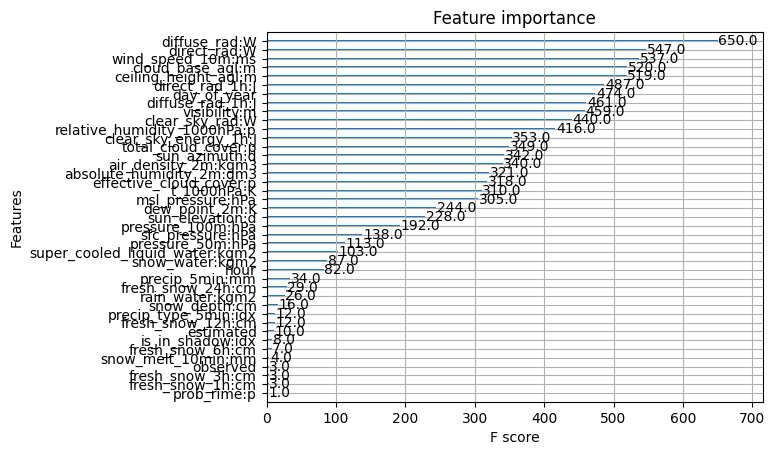

In [22]:
plot_importance(predictor1)

In [11]:
X_2, y_2 = df2_0[[c for c in df2_0.columns if "pv_measurement" != c]], df2_0["pv_measurement"]

In [12]:
study2 = optuna.create_study(direction="minimize")

# Optimize the objective function
print("Optimizing hyperparameters...")
study2.optimize(get_objective(X=X_2,y=y_2 ), n_trials=1)
print("Optimization complete!")
predictor2 = XGBRegressor(**study2.best_params).fit(X_2, y_2)


[I 2023-11-10 18:21:10,292] A new study created in memory with name: no-name-5251dedb-3976-4cc4-af12-48c2d6086afc
/var/folders/y8/9glnt_6110xftbsjpdqd12280000gp/T/ipykernel_70332/4123539858.py:15: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  "subsample": trial.suggest_discrete_uniform("subsample", 0.6, 1.0, 0.05),  # Reduce the range
/var/folders/y8/9glnt_6110xftbsjpdqd12280000gp/T/ipykernel_70332/4123539858.py:16: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.6, 1.0, 0.05),  # Reduce the range


Optimizing hyperparameters...
Training Fold 1...
Fold 1 MAE: 58.370560587021345
Training Fold 2...


[I 2023-11-10 18:21:21,321] Trial 0 finished with value: 58.888319480692175 and parameters: {'tree_method': 'approx', 'max_depth': 9, 'learning_rate': 0.9098928879870335, 'n_estimators': 576, 'min_child_weight': 7, 'gamma': 0.31195507164615166, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.9442315291184267, 'reg_lambda': 0.9467439396259895, 'random_state': 199}. Best is trial 0 with value: 58.888319480692175.


Fold 2 MAE: 59.406078374363
Mean MAE for all Folds: 58.888319480692175
Optimization complete!


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

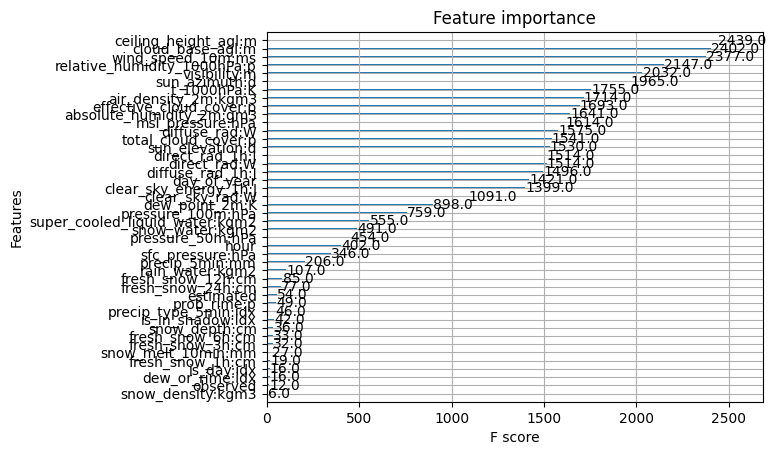

In [23]:
plot_importance(predictor2)

In [13]:
X_3, y_3 = df3_0[[c for c in df3_0.columns if "pv_measurement" != c]], df3_0["pv_measurement"]

In [14]:
study3 = optuna.create_study(direction="minimize")

# Optimize the objective function
print("Optimizing hyperparameters...")
study3.optimize(get_objective(X=X_3,y=y_3 ), n_trials=1)
print("Optimization complete!")
predictor3 = XGBRegressor(**study3.best_params).fit(X_3, y_3)


[I 2023-11-10 18:21:25,208] A new study created in memory with name: no-name-e0f5706e-488f-46e1-a61a-a368eaa4727f
/var/folders/y8/9glnt_6110xftbsjpdqd12280000gp/T/ipykernel_70332/4123539858.py:15: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  "subsample": trial.suggest_discrete_uniform("subsample", 0.6, 1.0, 0.05),  # Reduce the range
/var/folders/y8/9glnt_6110xftbsjpdqd12280000gp/T/ipykernel_70332/4123539858.py:16: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.6, 1.0, 0.05),  # Reduce the range


Optimizing hyperparameters...
Training Fold 1...
Fold 1 MAE: 51.24486899461901
Training Fold 2...


[I 2023-11-10 18:21:32,686] Trial 0 finished with value: 51.27239416607777 and parameters: {'tree_method': 'hist', 'max_depth': 8, 'learning_rate': 0.8762946193676969, 'n_estimators': 706, 'min_child_weight': 3, 'gamma': 0.28580241384220484, 'subsample': 0.75, 'colsample_bytree': 0.95, 'reg_alpha': 0.5373289995186017, 'reg_lambda': 0.217555822086801, 'random_state': 869}. Best is trial 0 with value: 51.27239416607777.


Fold 2 MAE: 51.29991933753652
Mean MAE for all Folds: 51.27239416607777
Optimization complete!


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

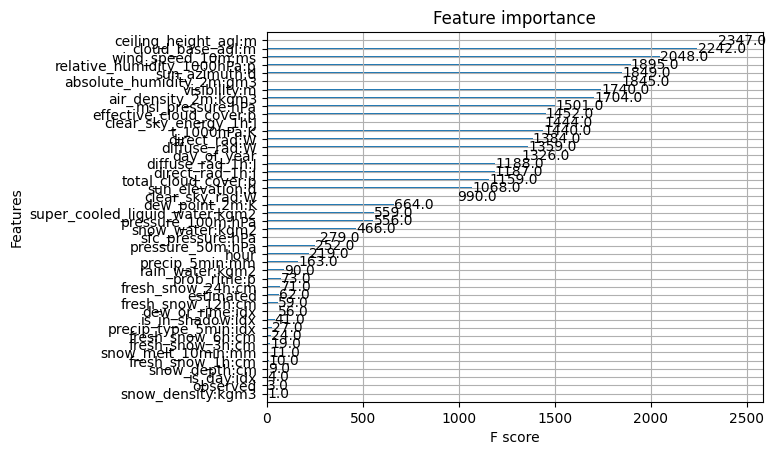

In [24]:
plot_importance(predictor3)

In [15]:
test1 = pipin.get_test_data("A")
test2 = pipin.get_test_data("B")
test3 = pipin.get_test_data("C")

test1 = pipin.drop_columns(test1)
test2 = pipin.drop_columns(test2)
test3 = pipin.drop_columns(test3)

In [16]:
pred1 = pd.DataFrame(predictor1.predict(test1), columns=["pv_measurement"])
pred2 = pd.DataFrame(predictor2.predict(test2), columns=["pv_measurement"])
pred3 = pd.DataFrame(predictor3.predict(test3), columns=["pv_measurement"])
negatives_pred1 = pred1[pred1["pv_measurement"] < 0]
negatives_pred2 = pred2[pred2["pv_measurement"] < 0]
negatives_pred3 = pred3[pred3["pv_measurement"] < 0]
neg = pd.concat([negatives_pred1, negatives_pred2, negatives_pred3])
neg.shape

(364, 1)

In [19]:
study1.bes

array(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d',
       'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'estimated', 'observed', 'day_of

In [17]:
# pred = pd.concat([pred1, pred2, pred3])
# final_prediction = pipin.post_processing(pred, prediction_column="pv_measurement")
# final_prediction.to_csv('submissions/XGB_143_pipeline.csv')

In [1]:
%load_ext autoreload

In [18]:
from sklearn.model_selection import KFold
import optuna
optuna.logging.set_verbosity(optuna.logging.INFO)

from sklearn.metrics import mean_absolute_error
from xgboost import XGBRFRegressor, plot_importance
import pandas as pd
import numpy as np

In [3]:
%autoreload
from pipeline import Pipeline
pipin = Pipeline()

Current working directory: /Users/miksx/GitHub/Forest-Gump/mikael/optuna


In [4]:
df1_0 = pipin.get_data("A")
df2_0 = pipin.get_data("B")
df3_0 = pipin.get_data("C")

In [5]:
# remove_consecutive_measurments
# 6/24
# dette skal prøve å gjenskape henning sin
df1_0 = pipin.remove_consecutive_measurments_new(df1_0, 4, 12)
df2_0 = pipin.remove_consecutive_measurments_new(df2_0, 4, 12)
df3_0 = pipin.remove_consecutive_measurments_new(df3_0, 4, 12)

In [6]:
df1_0 = pipin.drop_columns(df1_0)
df2_0 = pipin.drop_columns(df2_0)
df3_0 = pipin.drop_columns(df3_0)
print(df1_0.shape, df2_0.shape, df3_0.shape)

(23905, 47) (16471, 47) (13750, 47)


In [7]:
df1_0.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,estimated,observed,day_of_year,hour,pv_measurement
0,7.700,1.22825,1728.949951,0.000000,0.00,1728.949951,0.0,280.299988,0.000,0.000000,...,0.0,286.225006,100.000000,40386.476562,3.600,0.0,1.0,153.0,22.0,0.00
1,7.700,1.22350,1689.824951,0.000000,0.00,1689.824951,0.0,280.299988,0.000,0.000000,...,0.0,286.899994,100.000000,33770.648438,3.350,0.0,1.0,153.0,23.0,0.00
2,7.875,1.21975,1563.224976,0.000000,0.00,1563.224976,0.0,280.649994,0.000,0.000000,...,0.0,286.950012,100.000000,13595.500000,3.050,0.0,1.0,154.0,0.0,0.00
3,8.425,1.21800,1283.425049,208.649994,0.75,1283.425049,0.0,281.674988,0.300,526.775024,...,0.0,286.750000,100.000000,2321.850098,2.725,0.0,1.0,154.0,1.0,0.00
4,8.950,1.21800,1003.500000,32468.150391,23.10,1003.500000,0.0,282.500000,11.975,22068.949219,...,0.0,286.450012,99.224998,11634.799805,2.550,0.0,1.0,154.0,2.0,19.36


In [8]:
def get_objective(X=None, y=None):
    def objective(trial):
        kf = KFold(n_splits=2, shuffle=True, random_state=42)
        objective_list_reg = ["reg:squarederror", "reg:squaredlogerror"]
        tree_method = ["approx", "hist"]

        params = {
            "eval_metric": "mae",
            "objective": trial.suggest_categorical("objective", objective_list_reg),
            "tree_method": trial.suggest_categorical("tree_method", tree_method),
            "max_depth": trial.suggest_int("max_depth", 3, 10),  # Adjust the range
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
            "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),  # Increase the range
            "gamma": trial.suggest_float("gamma", 0.1, 1.0),  # Increase the lower bound
            "subsample": trial.suggest_discrete_uniform("subsample", 0.6, 1.0, 0.05),  # Reduce the range
            "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.6, 1.0, 0.05),  # Reduce the range
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 1.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 1.0),
            "random_state": trial.suggest_int("random_state", 1, 1000),
        }
        # Initialize a list to store the mean absolute errors for each fold
        mae_list = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
            y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

            print(f"Training Fold {fold}...")
            model = XGBRFRegressor(**params)
            model.fit(X_fold_train, y_fold_train)
            predictions = model.predict(X_fold_val)
            mae_fold = mean_absolute_error(y_fold_val, predictions)
            mae_list.append(mae_fold)
            print(f"Fold {fold} MAE: {mae_fold}")

        # Calculate the mean of the mean absolute errors for all folds
        mae = sum(mae_list) / len(mae_list)
        print(f"Mean MAE for all Folds: {mae}")
        return mae
    return objective

In [9]:
X_1, y_1 = df1_0[[c for c in df1_0.columns if "pv_measurement" != c]], df1_0["pv_measurement"]

In [10]:
study1 = optuna.create_study(direction="minimize")

# Optimize the objective function
print("Optimizing hyperparameters...")
study1.optimize(get_objective(X=X_1,y=y_1 ), n_trials=1)
print("Optimization complete!")

predictor1 = XGBRFRegressor(**study1.best_params).fit(X_1, y_1)


[I 2023-11-10 18:18:46,470] A new study created in memory with name: no-name-4eb38b6b-ee55-4f27-b9ef-5bd2df7b5a32


Optimizing hyperparameters...
Training Fold 1...


/var/folders/y8/9glnt_6110xftbsjpdqd12280000gp/T/ipykernel_70087/3434561556.py:16: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  "subsample": trial.suggest_discrete_uniform("subsample", 0.6, 1.0, 0.05),  # Reduce the range
/var/folders/y8/9glnt_6110xftbsjpdqd12280000gp/T/ipykernel_70087/3434561556.py:17: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.6, 1.0, 0.05),  # Reduce the range


Fold 1 MAE: 732.0839708783311
Training Fold 2...


[I 2023-11-10 18:19:00,011] Trial 0 finished with value: 730.4235669128672 and parameters: {'objective': 'reg:squarederror', 'tree_method': 'approx', 'max_depth': 9, 'learning_rate': 0.32548821433153435, 'n_estimators': 578, 'min_child_weight': 9, 'gamma': 0.8073099648976965, 'subsample': 0.9, 'colsample_bytree': 0.95, 'reg_alpha': 0.6189355660761848, 'reg_lambda': 0.47338850496867746, 'random_state': 942}. Best is trial 0 with value: 730.4235669128672.


Fold 2 MAE: 728.7631629474032
Mean MAE for all Folds: 730.4235669128672
Optimization complete!


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

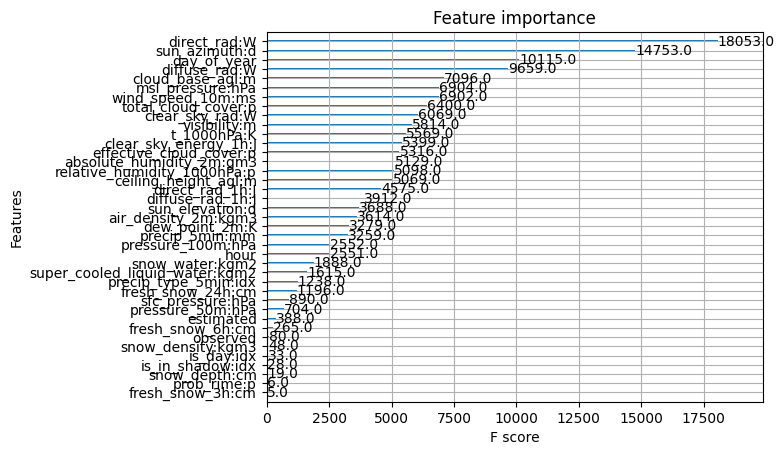

In [19]:
plot_importance(predictor1)

In [11]:
X_2, y_2 = df2_0[[c for c in df2_0.columns if "pv_measurement" != c]], df2_0["pv_measurement"]

In [12]:
study2 = optuna.create_study(direction="minimize")

# Optimize the objective function
print("Optimizing hyperparameters...")
study2.optimize(get_objective(X=X_2,y=y_2 ), n_trials=1)
print("Optimization complete!")
predictor2 = XGBRFRegressor(**study2.best_params).fit(X_2, y_2)


[I 2023-11-10 18:19:08,828] A new study created in memory with name: no-name-b9e74161-1755-4019-a8a0-1cf0214bdfbd
/var/folders/y8/9glnt_6110xftbsjpdqd12280000gp/T/ipykernel_70087/3434561556.py:16: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  "subsample": trial.suggest_discrete_uniform("subsample", 0.6, 1.0, 0.05),  # Reduce the range
/var/folders/y8/9glnt_6110xftbsjpdqd12280000gp/T/ipykernel_70087/3434561556.py:17: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.6, 1.0, 0.05),  # Reduce the range


Optimizing hyperparameters...
Training Fold 1...
Fold 1 MAE: 167.0674026253017
Training Fold 2...


[I 2023-11-10 18:19:21,727] Trial 0 finished with value: 167.62968100065274 and parameters: {'objective': 'reg:squaredlogerror', 'tree_method': 'approx', 'max_depth': 6, 'learning_rate': 0.4971157285140966, 'n_estimators': 803, 'min_child_weight': 7, 'gamma': 0.7336752949551839, 'subsample': 0.6, 'colsample_bytree': 1.0, 'reg_alpha': 0.3472041711073767, 'reg_lambda': 0.8958063552177049, 'random_state': 894}. Best is trial 0 with value: 167.62968100065274.


Fold 2 MAE: 168.19195937600378
Mean MAE for all Folds: 167.62968100065274
Optimization complete!


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

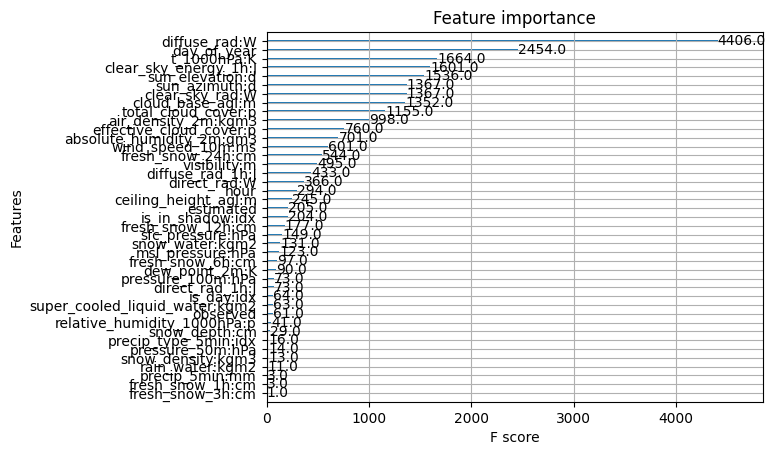

In [20]:
plot_importance(predictor2)

In [13]:
X_3, y_3 = df3_0[[c for c in df3_0.columns if "pv_measurement" != c]], df3_0["pv_measurement"]

In [14]:
study3 = optuna.create_study(direction="minimize")

# Optimize the objective function
print("Optimizing hyperparameters...")
study3.optimize(get_objective(X=X_3,y=y_3 ), n_trials=1)
print("Optimization complete!")
predictor3 = XGBRFRegressor(**study3.best_params).fit(X_3, y_3)


[I 2023-11-10 18:19:33,617] A new study created in memory with name: no-name-c1189ed3-28ff-430b-8a89-1010839f3783
/var/folders/y8/9glnt_6110xftbsjpdqd12280000gp/T/ipykernel_70087/3434561556.py:16: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  "subsample": trial.suggest_discrete_uniform("subsample", 0.6, 1.0, 0.05),  # Reduce the range
/var/folders/y8/9glnt_6110xftbsjpdqd12280000gp/T/ipykernel_70087/3434561556.py:17: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.6, 1.0, 0.05),  # Reduce the range


Optimizing hyperparameters...
Training Fold 1...
Fold 1 MAE: 146.81180846407204
Training Fold 2...


[I 2023-11-10 18:19:38,329] Trial 0 finished with value: 146.7127852164872 and parameters: {'objective': 'reg:squaredlogerror', 'tree_method': 'hist', 'max_depth': 3, 'learning_rate': 0.14993610585877482, 'n_estimators': 488, 'min_child_weight': 9, 'gamma': 0.21668401721684977, 'subsample': 0.85, 'colsample_bytree': 0.75, 'reg_alpha': 0.13938943419056793, 'reg_lambda': 0.14466106017358887, 'random_state': 557}. Best is trial 0 with value: 146.7127852164872.


Fold 2 MAE: 146.61376196890237
Mean MAE for all Folds: 146.7127852164872
Optimization complete!


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

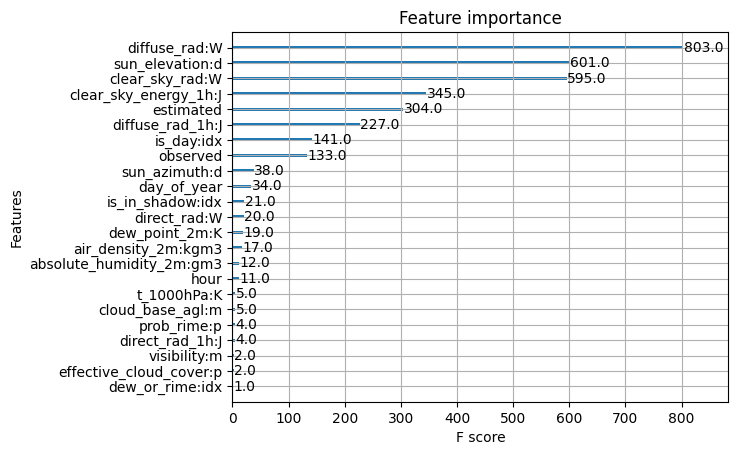

In [21]:
plot_importance(predictor3)

In [15]:
test1 = pipin.get_test_data("A")
test2 = pipin.get_test_data("B")
test3 = pipin.get_test_data("C")

test1 = pipin.drop_columns(test1)
test2 = pipin.drop_columns(test2)
test3 = pipin.drop_columns(test3)

In [16]:
pred1 = pd.DataFrame(predictor1.predict(test1), columns=["pv_measurement"])
pred2 = pd.DataFrame(predictor2.predict(test2), columns=["pv_measurement"])
pred3 = pd.DataFrame(predictor3.predict(test3), columns=["pv_measurement"])
negatives_pred1 = pred1[pred1["pv_measurement"] < 0]
negatives_pred2 = pred2[pred2["pv_measurement"] < 0]
negatives_pred3 = pred3[pred3["pv_measurement"] < 0]
neg = pd.concat([negatives_pred1, negatives_pred2, negatives_pred3])
neg.shape

(132, 1)

In [17]:
# pred = pd.concat([pred1, pred2, pred3])
# final_prediction = pipin.post_processing(pred, prediction_column="pv_measurement")
# final_prediction.to_csv('submissions/XGB_RF_143_pipeline.csv')

In [1]:
%load_ext autoreload

In [21]:
from sklearn.model_selection import KFold
import optuna
optuna.logging.set_verbosity(optuna.logging.INFO)
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%autoreload
from pipeline import Pipeline
pipin = Pipeline()

Current working directory: /Users/miksx/GitHub/Forest-Gump/mikael/optuna


In [4]:
PATH = "ag_144_"

In [5]:
df1_0 = pipin.get_data("A")
df2_0 = pipin.get_data("B")
df3_0 = pipin.get_data("C")

In [6]:
# remove_consecutive_measurments
# 6/24
# dette skal prøve å gjenskape henning sin
df1_0 = pipin.remove_consecutive_measurments_new(df1_0, 4, 15)
df2_0 = pipin.remove_consecutive_measurments_new(df2_0, 4, 15)
df3_0 = pipin.remove_consecutive_measurments_new(df3_0, 4, 15)

In [7]:
df1_0 = pipin.drop_columns(df1_0)
df2_0 = pipin.drop_columns(df2_0)
df3_0 = pipin.drop_columns(df3_0)
print(df1_0.shape, df2_0.shape, df3_0.shape)

(26438, 47) (18422, 47) (15611, 47)


In [8]:
df1_0.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,estimated,observed,day_of_year,hour,pv_measurement
0,7.700,1.22825,1728.949951,0.000000,0.00,1728.949951,0.0,280.299988,0.000,0.000000,...,0.0,286.225006,100.000000,40386.476562,3.600,0.0,1.0,153.0,22.0,0.00
1,7.700,1.22350,1689.824951,0.000000,0.00,1689.824951,0.0,280.299988,0.000,0.000000,...,0.0,286.899994,100.000000,33770.648438,3.350,0.0,1.0,153.0,23.0,0.00
2,7.875,1.21975,1563.224976,0.000000,0.00,1563.224976,0.0,280.649994,0.000,0.000000,...,0.0,286.950012,100.000000,13595.500000,3.050,0.0,1.0,154.0,0.0,0.00
3,8.425,1.21800,1283.425049,208.649994,0.75,1283.425049,0.0,281.674988,0.300,526.775024,...,0.0,286.750000,100.000000,2321.850098,2.725,0.0,1.0,154.0,1.0,0.00
4,8.950,1.21800,1003.500000,32468.150391,23.10,1003.500000,0.0,282.500000,11.975,22068.949219,...,0.0,286.450012,99.224998,11634.799805,2.550,0.0,1.0,154.0,2.0,19.36


In [9]:
def get_objective(X=None, y=None):
    def objective(trial):
        kf = KFold(n_splits=2, shuffle=True, random_state=42)

        params = {
            "iterations": 500,
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
            "depth": trial.suggest_int("depth", 4, 10),
            "subsample": trial.suggest_float("subsample", 0.05, 1.0),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        }
        # Initialize a list to store the mean absolute errors for each fold
        mae_list = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
            y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

            print(f"Training Fold {fold}...")
            model = CatBoostRegressor(**params, silent=True)
            model.fit(X_fold_train, y_fold_train)
            predictions = model.predict(X_fold_val)
            mae_fold = mean_absolute_error(y_fold_val, predictions)
            mae_list.append(mae_fold)
            print(f"Fold {fold} MAE: {mae_fold}")

        # Calculate the mean of the mean absolute errors for all folds
        mae = sum(mae_list) / len(mae_list)
        print(f"Mean MAE for all Folds: {mae}")
        return mae
    return objective

In [10]:
X_1, y_1 = df1_0[[c for c in df1_0.columns if "pv_measurement" != c]], df1_0["pv_measurement"]

In [11]:
study1 = optuna.create_study(direction="minimize")

# Optimize the objective function
print("Optimizing hyperparameters...")
study1.optimize(get_objective(X=X_1,y=y_1 ), n_trials=1)
print("Optimization complete!")

predictor1 = CatBoostRegressor(**study1.best_params).fit(X_1, y_1)


[I 2023-11-10 18:19:24,985] A new study created in memory with name: no-name-a11350fa-d6a5-4df8-b2ea-36531ea6bbbd


Optimizing hyperparameters...
Training Fold 1...
Fold 1 MAE: 355.67649381696117
Training Fold 2...


[I 2023-11-10 18:19:28,919] Trial 0 finished with value: 352.13427372942704 and parameters: {'learning_rate': 0.003898703780850047, 'depth': 6, 'subsample': 0.7766926077009079, 'colsample_bylevel': 0.5811250621341761, 'min_data_in_leaf': 73}. Best is trial 0 with value: 352.13427372942704.


Fold 2 MAE: 348.59205364189285
Mean MAE for all Folds: 352.13427372942704
Optimization complete!
0:	learn: 1262.7608368	total: 5.75ms	remaining: 5.75s
1:	learn: 1258.9799836	total: 12.6ms	remaining: 6.27s
2:	learn: 1255.1480783	total: 17.2ms	remaining: 5.72s
3:	learn: 1251.3318204	total: 22.3ms	remaining: 5.56s
4:	learn: 1247.5938657	total: 26.6ms	remaining: 5.29s
5:	learn: 1243.8276697	total: 31.9ms	remaining: 5.29s
6:	learn: 1240.0540563	total: 36.1ms	remaining: 5.12s
7:	learn: 1236.3385820	total: 41.4ms	remaining: 5.13s
8:	learn: 1232.6569150	total: 47.2ms	remaining: 5.2s
9:	learn: 1229.0817298	total: 50.7ms	remaining: 5.02s
10:	learn: 1225.4436233	total: 55.3ms	remaining: 4.97s
11:	learn: 1221.9253367	total: 60ms	remaining: 4.94s
12:	learn: 1218.3725963	total: 65.7ms	remaining: 4.99s
13:	learn: 1214.7800120	total: 69.8ms	remaining: 4.92s
14:	learn: 1211.1543884	total: 75.2ms	remaining: 4.94s
15:	learn: 1207.5304862	total: 81.7ms	remaining: 5.02s
16:	learn: 1204.0141365	total: 86.4m

Text(0.5, 1.0, 'Feature Importance')

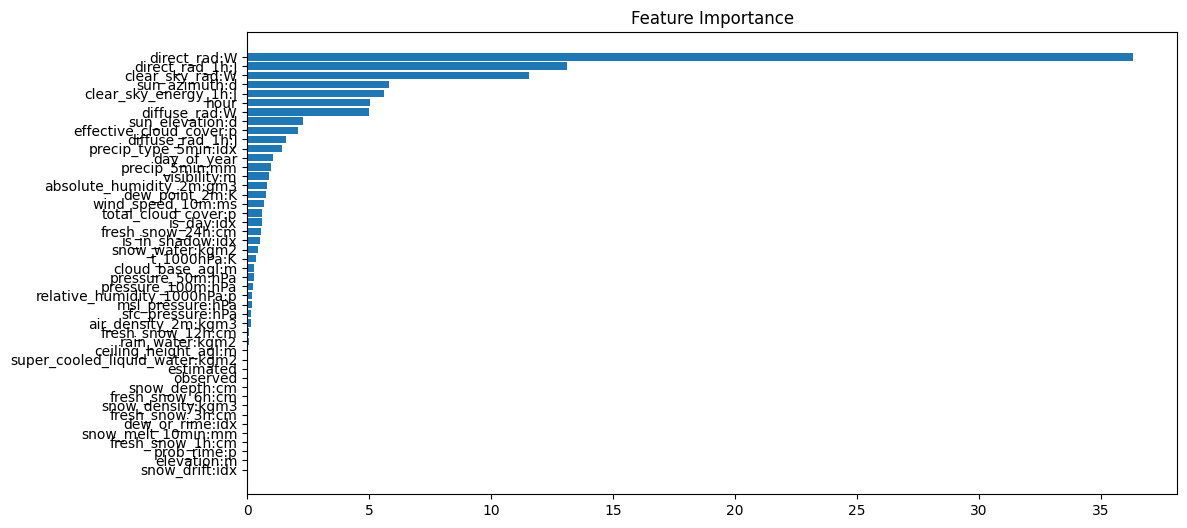

In [22]:
feature_importance = predictor1.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_1.columns)[sorted_idx])
plt.title('Feature Importance')

In [12]:
X_2, y_2 = df2_0[[c for c in df2_0.columns if "pv_measurement" != c]], df2_0["pv_measurement"]

In [13]:
study2 = optuna.create_study(direction="minimize")

# Optimize the objective function
print("Optimizing hyperparameters...")
study2.optimize(get_objective(X=X_2,y=y_2 ), n_trials=1)
print("Optimization complete!")
predictor2 = CatBoostRegressor(**study2.best_params).fit(X_2, y_2)


[I 2023-11-10 18:19:33,855] A new study created in memory with name: no-name-e2c903d8-6564-40cb-9dc9-d60e59408acb


Optimizing hyperparameters...
Training Fold 1...
Fold 1 MAE: 83.05926131676746
Training Fold 2...


[I 2023-11-10 18:19:43,103] Trial 0 finished with value: 82.83207293237899 and parameters: {'learning_rate': 0.00218957417363213, 'depth': 9, 'subsample': 0.9368304668851243, 'colsample_bylevel': 0.6559927822482776, 'min_data_in_leaf': 64}. Best is trial 0 with value: 82.83207293237899.


Fold 2 MAE: 82.60488454799051
Mean MAE for all Folds: 82.83207293237899
Optimization complete!
0:	learn: 238.3066632	total: 11.2ms	remaining: 11.1s
1:	learn: 237.8793455	total: 21ms	remaining: 10.5s
2:	learn: 237.4639698	total: 32.2ms	remaining: 10.7s
3:	learn: 237.0497615	total: 41.9ms	remaining: 10.4s
4:	learn: 236.6266111	total: 52.9ms	remaining: 10.5s
5:	learn: 236.1985247	total: 62.3ms	remaining: 10.3s
6:	learn: 235.7776540	total: 72.3ms	remaining: 10.3s
7:	learn: 235.3583132	total: 83.1ms	remaining: 10.3s
8:	learn: 234.9339940	total: 92.5ms	remaining: 10.2s
9:	learn: 234.5255734	total: 103ms	remaining: 10.2s
10:	learn: 234.1047286	total: 113ms	remaining: 10.1s
11:	learn: 233.6870671	total: 123ms	remaining: 10.2s
12:	learn: 233.2773231	total: 133ms	remaining: 10.1s
13:	learn: 232.8744387	total: 142ms	remaining: 10s
14:	learn: 232.4658481	total: 151ms	remaining: 9.93s
15:	learn: 232.0502280	total: 162ms	remaining: 9.98s
16:	learn: 231.6370397	total: 173ms	remaining: 9.98s
17:	learn

Text(0.5, 1.0, 'Feature Importance')

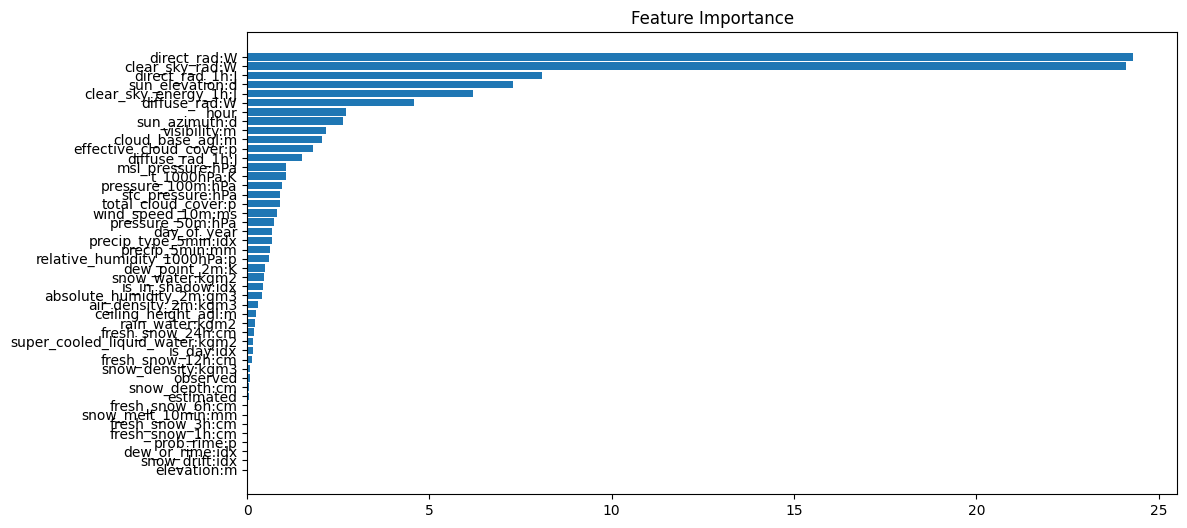

In [23]:
feature_importance = predictor2.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_2.columns)[sorted_idx])
plt.title('Feature Importance')

In [14]:
X_3, y_3 = df3_0[[c for c in df3_0.columns if "pv_measurement" != c]], df3_0["pv_measurement"]

In [15]:
study3 = optuna.create_study(direction="minimize")

# Optimize the objective function
print("Optimizing hyperparameters...")
study3.optimize(get_objective(X=X_3,y=y_3 ), n_trials=1)
print("Optimization complete!")
predictor3 = CatBoostRegressor(**study3.best_params).fit(X_3, y_3)


[I 2023-11-10 18:19:53,590] A new study created in memory with name: no-name-47506f41-939d-42ea-a656-0198e65f90d3


Optimizing hyperparameters...
Training Fold 1...
Fold 1 MAE: 34.76186896022819
Training Fold 2...


[I 2023-11-10 18:19:55,548] Trial 0 finished with value: 34.604372113855206 and parameters: {'learning_rate': 0.013394538025040795, 'depth': 7, 'subsample': 0.22614848861118847, 'colsample_bylevel': 0.1919168581015177, 'min_data_in_leaf': 33}. Best is trial 0 with value: 34.604372113855206.


Fold 2 MAE: 34.44687526748223
Mean MAE for all Folds: 34.604372113855206
Optimization complete!
0:	learn: 195.9445665	total: 2.84ms	remaining: 2.84s
1:	learn: 193.8566579	total: 4.88ms	remaining: 2.43s
2:	learn: 191.8294022	total: 6.68ms	remaining: 2.22s
3:	learn: 189.7849274	total: 10.2ms	remaining: 2.55s
4:	learn: 187.8076665	total: 12.4ms	remaining: 2.47s
5:	learn: 185.8396000	total: 15.4ms	remaining: 2.55s
6:	learn: 183.9004998	total: 17.9ms	remaining: 2.54s
7:	learn: 182.0254667	total: 19.8ms	remaining: 2.45s
8:	learn: 180.2508139	total: 22.1ms	remaining: 2.43s
9:	learn: 178.4117717	total: 24.9ms	remaining: 2.47s
10:	learn: 176.6081609	total: 27.2ms	remaining: 2.45s
11:	learn: 174.8925368	total: 28.9ms	remaining: 2.38s
12:	learn: 173.3024139	total: 31.3ms	remaining: 2.38s
13:	learn: 171.5538699	total: 34.4ms	remaining: 2.42s
14:	learn: 169.8018804	total: 36.7ms	remaining: 2.41s
15:	learn: 168.1531646	total: 38.9ms	remaining: 2.39s
16:	learn: 166.4481843	total: 40.6ms	remaining: 2.

Text(0.5, 1.0, 'Feature Importance')

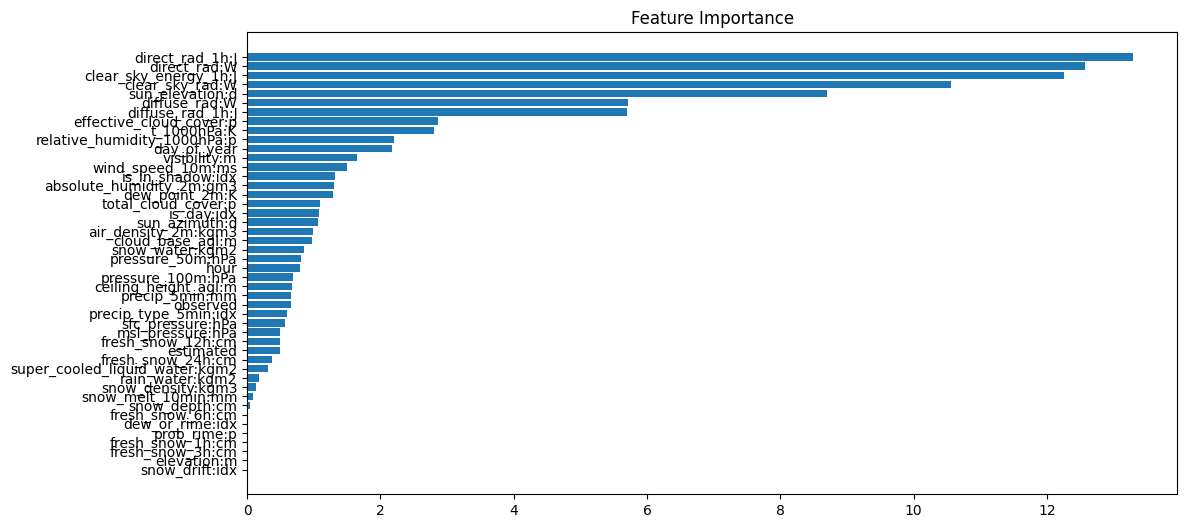

In [24]:
feature_importance = predictor3.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_3.columns)[sorted_idx])
plt.title('Feature Importance')

In [16]:
test1 = pipin.get_test_data("A")
test2 = pipin.get_test_data("B")
test3 = pipin.get_test_data("C")

test1 = pipin.drop_columns(test1)
test2 = pipin.drop_columns(test2)
test3 = pipin.drop_columns(test3)

In [17]:
pred1 = pd.DataFrame(predictor1.predict(test1), columns=["pv_measurement"])
pred2 = pd.DataFrame(predictor2.predict(test2), columns=["pv_measurement"])
pred3 = pd.DataFrame(predictor3.predict(test3), columns=["pv_measurement"])
negatives_pred1 = pred1[pred1["pv_measurement"] < 0]
negatives_pred2 = pred2[pred2["pv_measurement"] < 0]
negatives_pred3 = pred3[pred3["pv_measurement"] < 0]
neg = pd.concat([negatives_pred1, negatives_pred2, negatives_pred3])
neg.shape

(30, 1)

In [18]:
pred = pd.concat([pred1, pred2, pred3])
final_prediction = pipin.post_processing(pred, prediction_column="pv_measurement")
final_prediction.to_csv('submissions/catboost_143_pipeline.csv')

In [19]:
diff = pipin.compare_mae(final_prediction)
diff

86.50569969917758

In [20]:
# predictor.evaluate(df1, silent=True)